# Enhance: CSI-like machine learning

Libraries that will be used throughout the project

In [10]:
from urllib.request import urlretrieve
import os
import sys
import tarfile
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from IPython.display import display, Markdown
from sklearn.cross_validation import train_test_split
import tensorflow as tf

## Getting the data

Let's start by downloading our dataset.  
For this example we'll be using *Caltech256*, which can also be found here:  
http://www.vision.caltech.edu/Image_Datasets/Caltech256/

In [5]:
url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar'
filename = '256_ObjectCategories.tar'
root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz

def download():
    """ Download Caltech 256 database """
    if not os.path.exists(filename):
        urlretrieve(url, filename, reporthook=reporthook)
        print('Image database downloaded')
    else:
        print('Valid file found, skipping download')

last_percent_reported = None
def reporthook(count, blockSize, totalSize):
    """ Report download progress """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    if last_percent_reported != percent:
        message = ("%s%%" % percent) if percent % 10 == 0 else "."
        print(message, end="")
        last_percent_reported = percent

def uncompress():
    """ Uncompress the file """
    if os.path.isdir(root):
        print('%s folder found, skipping extraction' % root)
    else:
        print('Extracting data...')
        tar = tarfile.open(filename)
        tar.extractall()
        tar.close()
        
# Do it!
download()
uncompress()
print('Done!')

Valid file found, skipping download
256_ObjectCategories folder found, skipping extraction
Done!


## Conversion

Now that we have the database we need to normalize all images.  
We are going to resize all of them to 128x128, and create their smaller counterparts.  
These will be our data and labels.

In [6]:
original_size = (128, 128)
small_size = (64, 64)

# Get list of all image folders
image_folders = [ os.path.join(root, d) for d in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, d))]

# Create output folder
if not os.path.exists('data'):
    os.mkdir('data')
    os.mkdir('data/X')
    os.mkdir('data/y')
    
def process_image(image_path):
    """ Resizes an image, creating a big and a reduced version """
    
    # Skip files that already were generated or directories
    if os.path.exists(os.path.join('data/y', file)) or not image_path.endswith("jpg"):
        return
    
    with Image.open(image_path) as original:
  
        # Ignore images smaller than our target size
        if original.size[0] < original_size[0] or original.size[1] < original_size[1]:
            # print("image %s with size %s is too small, skipping..." % (image_path, original.size))
            return

        #print("resizing and cropping: %s" % image_path)
        center = (original.size[0]/2, original.size[1]/2)
        size = min(original.size)
        cropped = original.crop((center[0] - size/2, 
                                 center[1] - size/2, 
                                 center[0] + size/2,
                                 center[1] + size/2))
        cropped = cropped.resize(original_size, Image.ANTIALIAS)
        cropped.save(os.path.join('data/y', file))
        small = cropped.resize(small_size, Image.ANTIALIAS)
        small.save(os.path.join('data/X', file))

for folder in image_folders:
    #print("Processing folder %s" % (folder))
    print(".", end="")
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        process_image(image_path)
        
print("Done!")

.................................................................................................................................................................................................................................................................Done!


## Normalization

Now that we have all files in the desired sizes, it's time to load them into a format that TensorFlow can actually understand.  
We'll also convert them intro grayscale to reduce the dimensionality of the data and speed up our computations.

In [9]:
pixel_depth = 255.0

# Limit dataset limit since we don't have that much memory =]
image_limit = 20000

def load_folder(folder, image_size):
    """load data into a tensor"""
    
    pickle_file = folder + ".pickle"
    if os.path.exists(pickle_file):
        print("pickle already exists, loading it!")
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    
    image_files = os.listdir(folder)[:image_limit]
    dataset = np.ndarray(shape=(len(image_files), image_size[0], image_size[1]),
                         dtype=np.float32)
    print("Loading folder %s " % folder)
    
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        # Load image as grayscale/luminance, flattening it
        image_data = (ndimage.imread(image_file, False, mode='L').astype(float) - pixel_depth / 2) / pixel_depth
        if image_data.shape != image_size:
            raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[num_images, :, :] = image_data
        num_images = num_images + 1
        
    # Save file, so we can load it later on other notebooks
    with open(pickle_file, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset

X = load_folder('data/X', small_size)
print("")
y = load_folder('data/y', original_size)

Loading folder data/X 
Full dataset tensor: (20000, 64, 64)
Mean: 0.0179591
Standard deviation: 0.296698

Loading folder data/y 
Full dataset tensor: (20000, 128, 128)
Mean: 0.0183412
Standard deviation: 0.302526


## Train / test / validation split

In [19]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

X, y = randomize(X, y)
X_train, X_test, y_train, y_test  = train_test_split(X, y)

# Split test in test/validation
X_valid, X_test, y_valid, y_test  = train_test_split(X_test, y_test, test_size=0.5)

print("Total shape: %s, %s\n" % (X.shape, y.shape))
print("Train shape: %s, %s" % (X_train.shape, y_train.shape))
print("Test shape: %s, %s" % (X_test.shape, y_test.shape))
print("Valid shape: %s, %s" % (X_valid.shape, y_valid.shape))

Total shape: (20000, 64, 64), (20000, 128, 128)

Train shape: (15000, 64, 64), (15000, 128, 128)
Test shape: (2500, 64, 64), (2500, 128, 128)
Valid shape: (2500, 64, 64), (2500, 128, 128)


## Analysis

Taking a look at the data to make sure it's still clean:

### Standard deviation

'Of dataset'

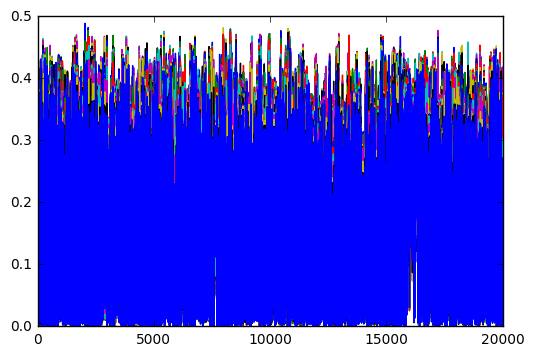

'Of labels'

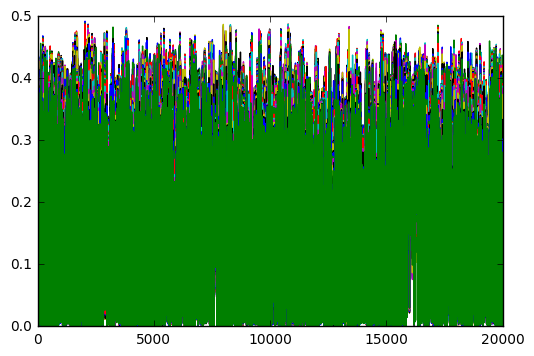

In [143]:
display(Markdown("### Standard deviation"))
display("Of dataset")
plt.plot(X.std(axis=1))
plt.show()

display("Of labels")
plt.plot(y.std(axis=1))
plt.show()


### Image samples

image pair


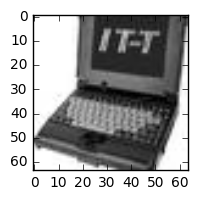

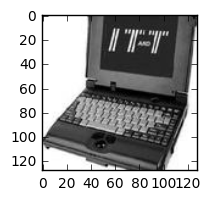

image pair


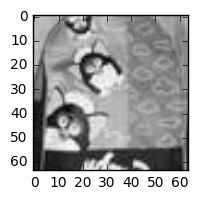

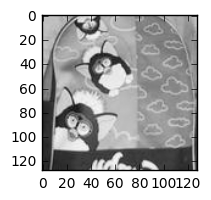

image pair


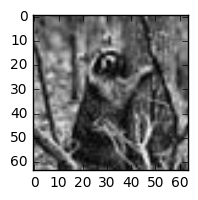

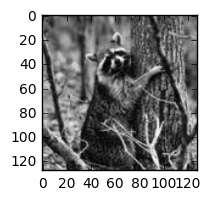

image pair


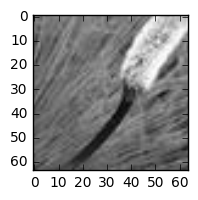

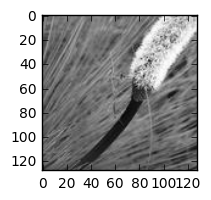

image pair


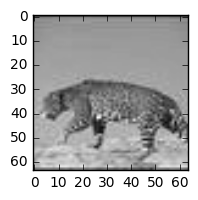

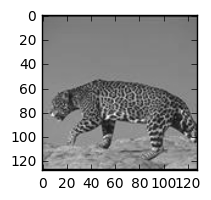

In [20]:
display(Markdown("### Image samples"))
for _ in range(5):
    _x, _y = random.choice(list(zip(X, y)))
    print("image pair")
    plt.figure(figsize = (2, 2))
    plt.imshow(_x, cmap="gray")
    plt.show()
    plt.figure(figsize = (2, 2))
    plt.imshow(_y, cmap="gray")
    plt.show()